# Temperature Forecast
**Predicting tomorrow's temperature based on a time series analysis of temperature data from 1876 to today.**  
_Jan Kühn, May 2023_

In [1]:
import itertools
import time

import helpers_timeseries as hlp
import joblib
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pmdarima as pm
import seaborn as sns
from scipy import fft
from scipy import signal as sig
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, PolynomialFeatures

In [2]:
%matplotlib inline
sns.set_style('whitegrid')

## Import data

First we import the data. This information is bundled with the file from ecad.eu:

> EUROPEAN CLIMATE ASSESSMENT & DATASET (ECA&D), file created on 08-05-2023  
> THESE DATA CAN BE USED FREELY PROVIDED THAT THE FOLLOWING SOURCE IS ACKNOWLEDGED:
> 
> Klein Tank, A.M.G. and Coauthors, 2002. Daily dataset of 20th-century surface  
> air temperature and precipitation series for the European Climate Assessment.  
> Int. J. of Climatol., 22, 1441-1453.  
> Data and metadata available at http://www.ecad.eu  
> 
> FILE FORMAT (MISSING VALUE CODE IS -9999):  
> 
> 01-06 SOUID: Source identifier  
> 08-15 DATE : Date YYYYMMDD  
> 17-21 TG   : mean temperature in 0.1 &#176;C  
> 23-27 Q_TG : Quality code for TG (0='valid'; 1='suspect'; 9='missing')  
> 
> This is the blended series of station GERMANY, BERLIN-TEMPELHOF (STAID: 2759).  
> Blended and updated with sources: 111448 127488 128124   
> See file sources.txt and stations.txt for more info.

Source: https://www.ecad.eu/utils/showselection.php?oo8sk8dr3n14m8tb21ejl2hckn


In [3]:
df_raw = pd.read_csv(
    "data/TG_STAID002759.txt",
    skiprows=19,
    header=0,
    skipinitialspace=True,
    names=["id", "date", "mean_temp", "quality"],
    usecols=["date", "mean_temp", "quality"],
    parse_dates=["date"],
)

# Keep the raw data and work with a copy
df = df_raw.copy()

## Have a first look at the data

In [4]:
df.head()

,date,mean_temp,quality
0,1876-01-01,22,0
1,1876-01-02,25,0
2,1876-01-03,3,0
3,1876-01-04,-58,0
4,1876-01-05,-98,0


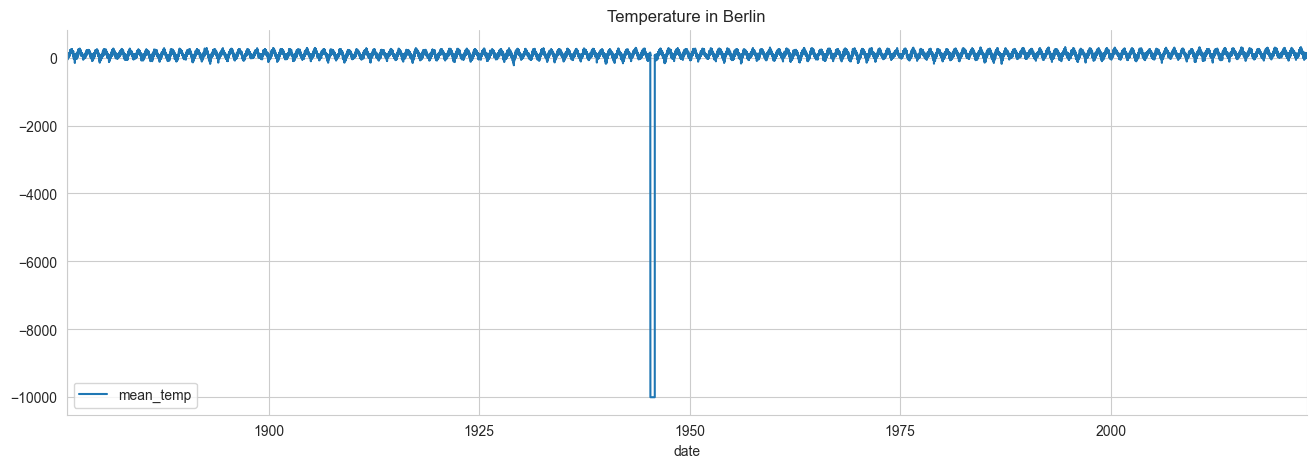

In [5]:
# Plot the data
mpl.rc("figure", figsize=(16, 5))
df.plot(legend=True, x="date", y="mean_temp", title="Temperature in Berlin")
sns.despine()

We can clearly see the seasonal pattern in the data and that there are missing values (-9999) in the 1940s. We'll have to handle those.

## Clean data

### Convert to °C

Since the original data is in 0.1 °C, we need to convert it to °C by dividing by 10.

In [6]:
df["mean_temp"] = df["mean_temp"] / 10

### Impute missing values

Analyzing the data, we see that there are missing values for the year 1945. We will impute them with the average of the temperatures on the same day over all the reference years.

In [7]:
missing_date_min = df[df["quality"] == 9]["date"].min()
missing_date_max = df[df["quality"] == 9]["date"].max()
days_period = (missing_date_max - missing_date_min).days + 1

print(f"Minimum date of missing: {missing_date_min}")
print(f"Maximum date of missing: {missing_date_max}")
print(f"Days between dates: {days_period}")
print(f"Number of missing values: {df[df['quality'] == 9].shape[0]}")

Minimum date of missing: 1945-04-25 00:00:00
Maximum date of missing: 1945-11-05 00:00:00
Days between dates: 195
Number of missing values: 195


In [8]:
# Create clean temperature column with imputed values
df["temp"] = df.apply(lambda x: hlp.clean_temp(df, x), axis=1)

### Add timestep column

For the time series analysis, we need to add a timestep column that will be used as the index.

In [9]:
# Add timestep column
df["timestep"] = list(range(df.shape[0]))

### Select subset of data

In [10]:
df_clean = df[["date", "timestep", "temp"]].set_index("date").copy()
df_clean.head()

,timestep,temp
date,,
1876-01-01,0,2.2
1876-01-02,1,2.5
1876-01-03,2,0.3
1876-01-04,3,-5.8
1876-01-05,4,-9.8


## Visualize some aspects

By resampling the data to a a 25 year period, we can clearly see a trend in the data. The temperature is increasing over time after the 1920s.

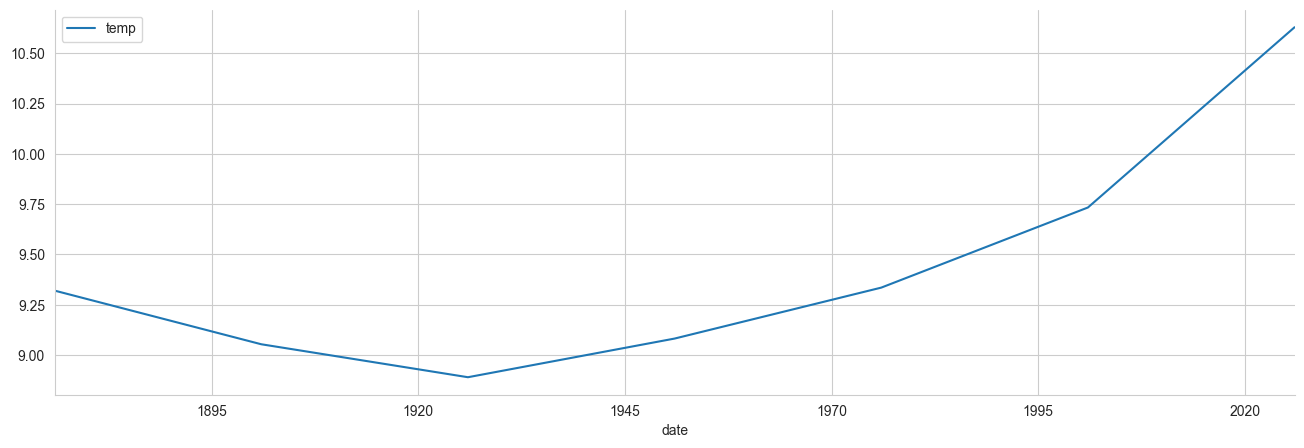

In [11]:
hlp.resampled_mean_plot(df_clean["temp"], 25)

The rolling mean is a bit more nuanced, but shows a similar trend.

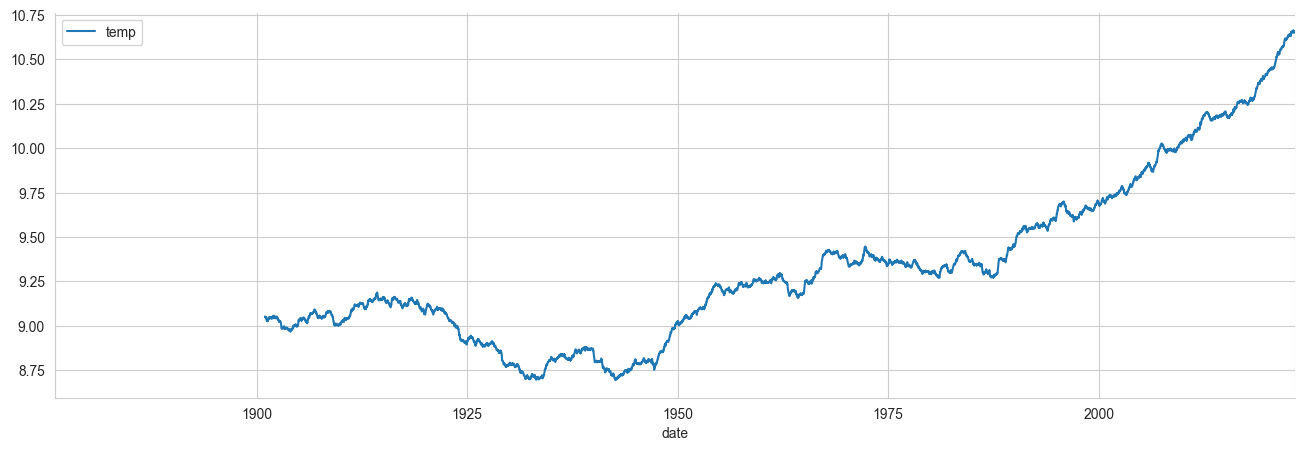

In [12]:
hlp.rolling_mean_plot(df_clean["temp"], 25)

## Train-test split

Next, we split the data into a training and a test set. We will use the last 90 days as the test set.

In [13]:
# Define train data (until end of Dec 2022)
train = df_clean[:"2022-12-31"].copy()

# Define test data (from Jan 2023)
test = df_clean["2023-01-01":].copy()

In [14]:
train.shape, test.shape

((53691, 2), (90, 2))

## Denoise data

As a first step, we denoise the data. We save the noise for later use.

In [15]:
# Smoothing based on the nearest 99 points
train["denoised"] = sig.savgol_filter(np.array(train["temp"]), 99, 3, mode="nearest")
train["noise"] = train["temp"] - train["denoised"]

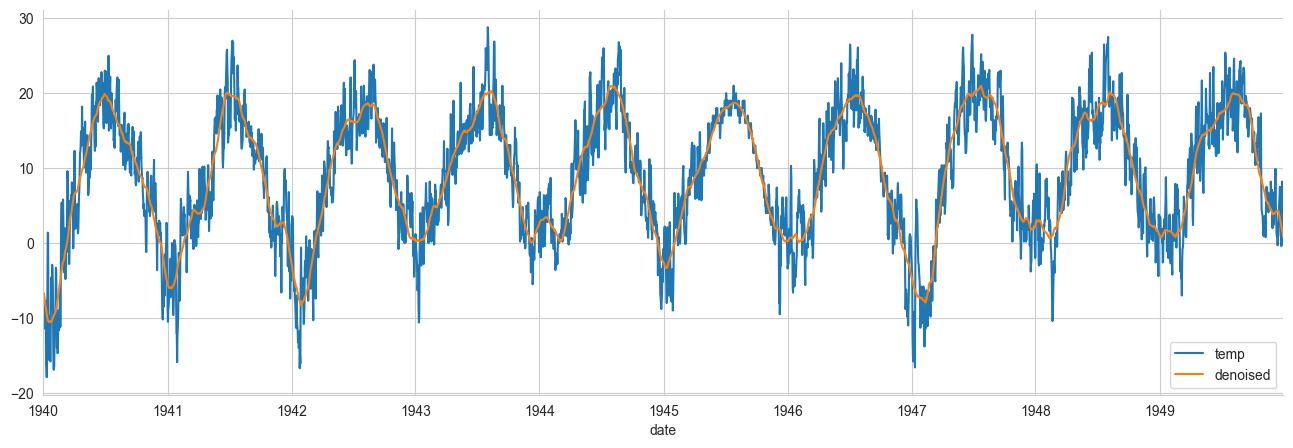

In [16]:
# Plot the demoised data on top of the original data
df_plot = train[train.index.year.isin(range(1940, 1950))]

mpl.rc("figure", figsize=(16, 5))
df_plot[["temp", "denoised"]].plot(legend=True)
sns.despine()

## Model the trend

Next, we extract the trend from the data. We will use a linear regression model for this.

In [17]:
# Feature and target for trend model
X_trend = train[["timestep"]]
y_trend = train["denoised"]

### Build trend model and tune hyperparameters

In [18]:
trend_model = Pipeline(
    [
        ("poly", PolynomialFeatures()),
        ("lr", LinearRegression()),
    ]
)

param_grid = {"poly__degree": [1, 2, 3, 4]}
cv = TimeSeriesSplit(n_splits=3)

gscv = GridSearchCV(
    estimator=trend_model, param_grid=param_grid, scoring="r2", cv=cv, n_jobs=-1
)

In [19]:
# Initial time
ti = time.time()

# Grid-search cross-validation
gscv.fit(X_trend, y_trend)

# Final time
tf = time.time()

# Time taken
print(f"Time taken: {round(tf-ti,2)} sec")
print(f"Best parameters: {gscv.best_params_}")

Time taken: 2.27 sec
Best parameters: {'poly__degree': 1}


In [20]:
# Use best estimator to fit the model
trend_model_cv = gscv.best_estimator_

# Fit model
trend_model_cv.fit(X_trend, y_trend)

Pipeline(steps=[('poly', PolynomialFeatures(degree=1)),
                ('lr', LinearRegression())])

In [21]:
# Save trained model
file_name = "models/model_trend.pkl"
joblib.dump(trend_model_cv, file_name)

['model_trend.pkl']

### Predict from model

Now we can predict the trend (`dn_trend`) - a very slow increase - for the training set and save the difference between the prediction and the actual data as the residuals (`dn_detrended`).

In [22]:
train["dn_trend"] = trend_model_cv.predict(X_trend)
train["dn_detrended"] = train["temp"] - train["dn_trend"]

In [23]:
train.head()

,timestep,temp,denoised,noise,dn_trend,dn_detrended
date,,,,,,
1876-01-01,0,2.2,-0.659391,2.859391,8.505986,-6.305986
1876-01-02,1,2.5,-0.772946,3.272946,8.506021,-6.006021
1876-01-03,2,0.3,-0.858296,1.158296,8.506055,-8.206055
1876-01-04,3,-5.8,-1.025494,-4.774506,8.506090,-14.306090
1876-01-05,4,-9.8,-1.151521,-8.648479,8.506124,-18.306124


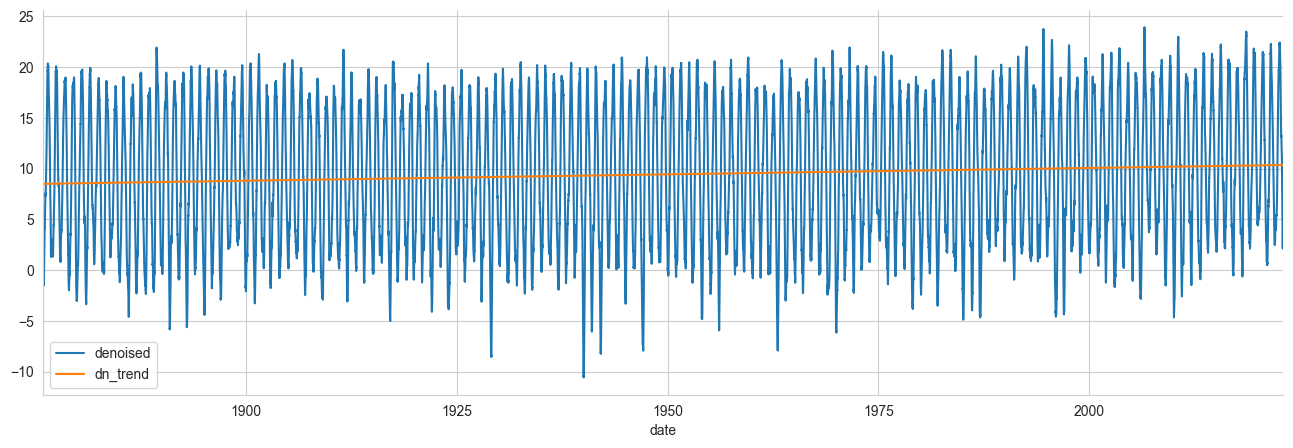

In [24]:
# Plot the trend of the denoised data on top of the denoised data
df_plot = train

mpl.rc("figure", figsize=(16, 5))
df_plot[["denoised", "dn_trend"]].plot(legend=True)
sns.despine()

## Model seasonality

Next, we use the detrendered data to model the seasonality.

Use denoised (dn_) and detrended (dt_) data

In [25]:
train.head()

,timestep,temp,denoised,noise,dn_trend,dn_detrended
date,,,,,,
1876-01-01,0,2.2,-0.659391,2.859391,8.505986,-6.305986
1876-01-02,1,2.5,-0.772946,3.272946,8.506021,-6.006021
1876-01-03,2,0.3,-0.858296,1.158296,8.506055,-8.206055
1876-01-04,3,-5.8,-1.025494,-4.774506,8.506090,-14.306090
1876-01-05,4,-9.8,-1.151521,-8.648479,8.506124,-18.306124


### Find peaks using Fourier transform

For better results, we try to find the peaks in the data using a Fourier transform.

Peak: 147 at 0.0027378890316812872 (every 365.24 days or 1.0 years). Power: 261375.89
Peak: 19 at 0.00035387681361866976 (every 2825.84 days or 7.72 years). Power: 9417.42
Peak: 65 at 0.001210631204484923 (every 826.02 days or 2.26 years). Power: 6823.17
Peak: 166 at 0.003091765845299957 (every 323.44 days or 0.88 years). Power: 6521.65
Peak: 61 at 0.0011361308226704662 (every 880.18 days or 2.4 years). Power: 6491.4
Peak: 300 at 0.0055875286360842595 (every 178.97 days or 0.49 years). Power: 6402.61
Peak: 863 at 0.016073457376469053 (every 62.21 days or 0.17 years). Power: 6073.94
Peak: 187 at 0.003482892849825855 (every 287.12 days or 0.78 years). Power: 5837.9
Peak: 129 at 0.0024026373135162316 (every 416.21 days or 1.14 years). Power: 5568.5
Peak: 245 at 0.004563148386135479 (every 219.15 days or 0.6 years). Power: 5554.72
Peak: 313 at 0.005829654876981245 (every 171.54 days or 0.47 years). Power: 5478.26
Peak: 947 at 0.017637965394572647 (every 56.7 days or 0.15 years). Power: 538

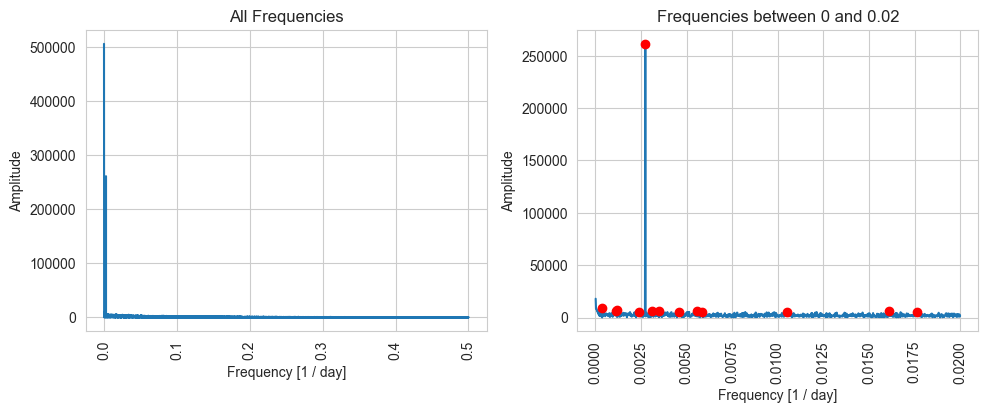

In [26]:
# Plotting power in the frequency domain (Fourier transformation)
# Adapted from https://github.com/Kommandat/seasonality-fourier-analysis

# Some settings
series = train["temp"]  # Series of values to be used
freq_low, freq_high = 0, 0.02  # x-axis boundaries for selection
min_power = 5000  # Threshold for calculation of peaks
num_peaks = 15  # Number of highest peaks to show

###

fft_output = fft.fft(series.values)
power = np.abs(fft_output)
freq = fft.fftfreq(len(series))

plt.figure(figsize=(10, 4))

# First look at all frequencies
mask = freq >= 0
freq = freq[mask]
power = power[mask]

ax1 = plt.subplot(1, 2, 1)
ax1.plot(freq, power, label="signal")
ax1.set_title("All Frequencies")
ax1.set_ylabel("Amplitude")
ax1.set_xlabel("Frequency [1 / day]")
plt.xticks(rotation=90)

# Look at a selection of frequences
mask = (freq > freq_low) & (freq <= freq_high)

ax2 = plt.subplot(1, 2, 2)
ax2.plot(freq[mask], power[mask])
ax2.set_title(f"Frequencies between {freq_low} and {freq_high}")
ax2.set_ylabel("Amplitude")
ax2.set_xlabel("Frequency [1 / day]")

# Find peaks
peaks = sig.find_peaks(power[freq >= freq], prominence=min_power)[0]
peak_freq = freq[peaks]
peak_power = power[peaks]

# Oder peaks by power DESC and limit their number
peaks = peaks[(-peak_power).argsort()][:num_peaks]
peak_freq = peak_freq[(-peak_power).argsort()][:num_peaks]
peak_power = peak_power[(-peak_power).argsort()][:num_peaks]

# Add markers for peaks
plt.plot(peak_freq, peak_power, "ro")

plt.tight_layout()
plt.xticks(rotation=90)
# plt.yscale("log")
# plt.ylim(0, 10000)

for pe, fr, po in zip(peaks, peak_freq, peak_power):
    print(
        f"Peak: {pe} at {fr} (every {round(1/fr, 2)} days "
        f"or {round(1/fr/366.24, 2)} years). Power: {round(po, 2)}"
    )

# Save frequencies of highest peaks for later use
best_freqs = list(peak_freq[:5])

We can see that there are multiple patterns of different intensity. As could be expected, the strongest pattern is the annual cycle (every 365.24 days).

### Define features and target

In [27]:
X_seasonality = train[["timestep"]].copy()
y_seasonality = train["dn_detrended"].copy()

### Build seasonality model

In [28]:
# Create new features
preprocessor = Pipeline(
    steps=[
        ("sin_cos", FunctionTransformer(hlp.calc_seas, validate=False)),
    ]
)

# Seasonality model
seasonality_model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("poly", PolynomialFeatures()),
        ("lr", LinearRegression()),
    ]
)

### Tune hyperparameters

In [29]:
# Alternatively use all possible combinations of best frequencies:
# freq = [{"frequency":v} for (k,v) in enumerate(list(itertools.permutations(best_freqs[:3], r=3)))]

# Use combinations of the three highest peaks
freq = [
    {"frequency": best_freqs[:1]},
    {"frequency": best_freqs[:2]},
    {"frequency": best_freqs[:3]},
    {"frequency": best_freqs[1:3]},
    {"frequency": best_freqs[2:3]},
    {"frequency": best_freqs[2]},
    {"frequency": best_freqs[3]},
]

param_grid = {
    "poly__degree": [1, 2, 3],
    "preprocessor__sin_cos__kw_args": freq,
}
cv = TimeSeriesSplit(n_splits=3)

gscv = GridSearchCV(
    estimator=seasonality_model, param_grid=param_grid, scoring="r2", cv=cv, n_jobs=-1
)

# Initial time
ti = time.time()

# Grid-search cross-validation
gscv.fit(X_seasonality, y_seasonality)

# Final time
tf = time.time()

# Time taken
print(f"Time taken: {round(tf-ti,2)} sec")
print(f"Best parameters: {gscv.best_params_}")

Time taken: 5.44 sec
Best parameters: {'poly__degree': 2, 'preprocessor__sin_cos__kw_args': {'frequency': [0.0027378890316812872]}}


In [30]:
# Use best estimator to fit the model
seasonality_model_cv = gscv.best_estimator_

# Fit model
seasonality_model_cv.fit(X_seasonality, y_seasonality)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('sin_cos',
                                  FunctionTransformer(func=<function calc_seas at 0x7f093dddab00>,
                                                      kw_args={'frequency': [0.0027378890316812872]}))])),
                ('poly', PolynomialFeatures()), ('lr', LinearRegression())])

In [31]:
# Save trained model
file_name = "models/model_seasonality.pkl"
joblib.dump(seasonality_model_cv, file_name)

['model_seasonality.pkl']

### Evaluate

In [32]:
r2_ts = round(seasonality_model_cv.score(X_seasonality, y_seasonality), 6)
print(f"r2 score: {r2_ts}")

r2 score: 0.769565


### Predict from model

Now we can predict the seasonality (`dn_seasonal`) for the training set. We also save the combined values of trend and seasonality (`dn_trend_seasonal`).

In [33]:
train["dn_seasonal"] = seasonality_model_cv.predict(X_seasonality)

# Combine trend and seasonality
train['dn_trend_seasonal'] = train['dn_trend'] + train['dn_seasonal']

### Plot seasonality and detrended data

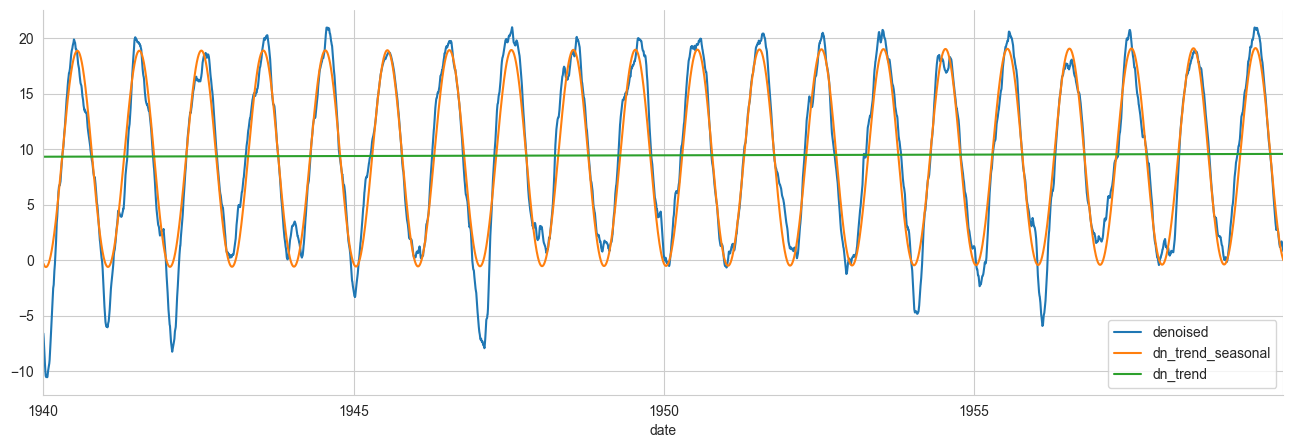

In [34]:
# Select a date range to show
df_plot = train[train.index.year.isin(range(1940, 1960))]

mpl.rc("figure", figsize=(16, 5))
df_plot[["denoised", "dn_trend_seasonal", "dn_trend"]].plot(legend=True)
sns.despine()

## Handle Remainder

Next we work on the remainder, i.e. the difference between the actual denoised data (`denoised`) and the trend and seasonality (`dn_trend_seasonal`).

In [35]:
# Leftover time series devoid of trend and seasonality
train['dn_remainder'] = train['denoised'] - train['dn_trend_seasonal']

- **temp:** Original temperature data
- **denoised:** Original data without the noise
- **noise:** Just the noise from the original data
- **dn_trend:** Trend of the denoised data
- **dn_detrended:** Denoised data without the trend
- **dn_seasonal:** Just the seasonal part of the denoised, detrendet data
- **dn_trend_seasonal:** Part of the denoised data explained by trend and seasonality
- **dn_remainder:** Remainder of the denoised data after trend and seasonality are removed

In [36]:
train.head()

,timestep,temp,denoised,noise,dn_trend,dn_detrended,dn_seasonal,dn_trend_seasonal,dn_remainder
date,,,,,,,,,
1876-01-01,0,2.2,-0.659391,2.859391,8.505986,-6.305986,-8.557284,-0.051298,-0.608093
1876-01-02,1,2.5,-0.772946,3.272946,8.506021,-6.006021,-8.595241,-0.089221,-0.683725
1876-01-03,2,0.3,-0.858296,1.158296,8.506055,-8.206055,-8.630509,-0.124453,-0.733842
1876-01-04,3,-5.8,-1.025494,-4.774506,8.506090,-14.306090,-8.663079,-0.156989,-0.868505
1876-01-05,4,-9.8,-1.151521,-8.648479,8.506124,-18.306124,-8.692948,-0.186824,-0.964698


### Plot remainder

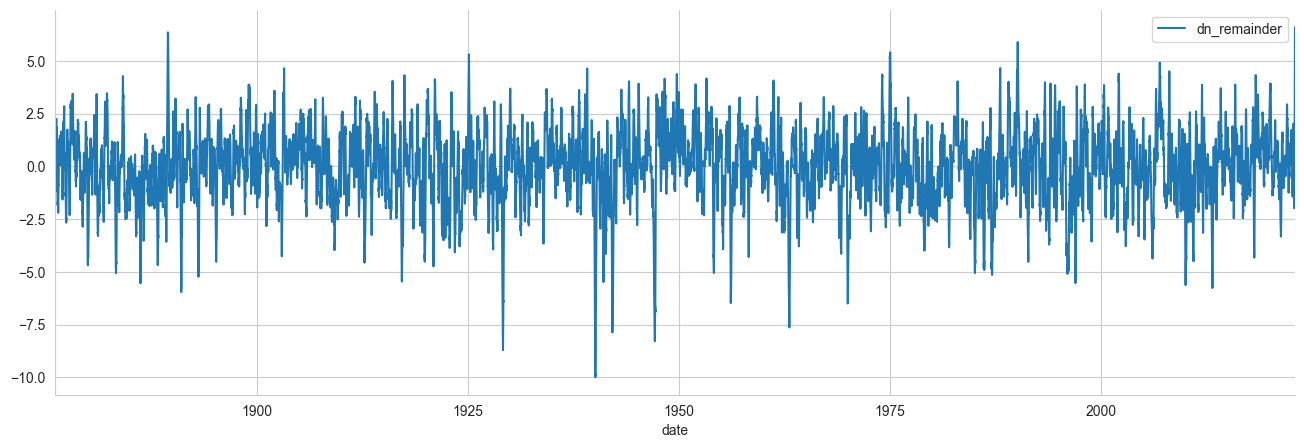

In [37]:
mpl.rc("figure", figsize=(16, 5))

train[["dn_remainder"]].plot(legend=True)
sns.despine()

### Check homoscedasticity and stationarity of the remainder

In [38]:
hlp.test_stationarity(train['dn_remainder'], qcd_window=100)


 Non-stationary: heteroscedastic (qcd = 0.599109)



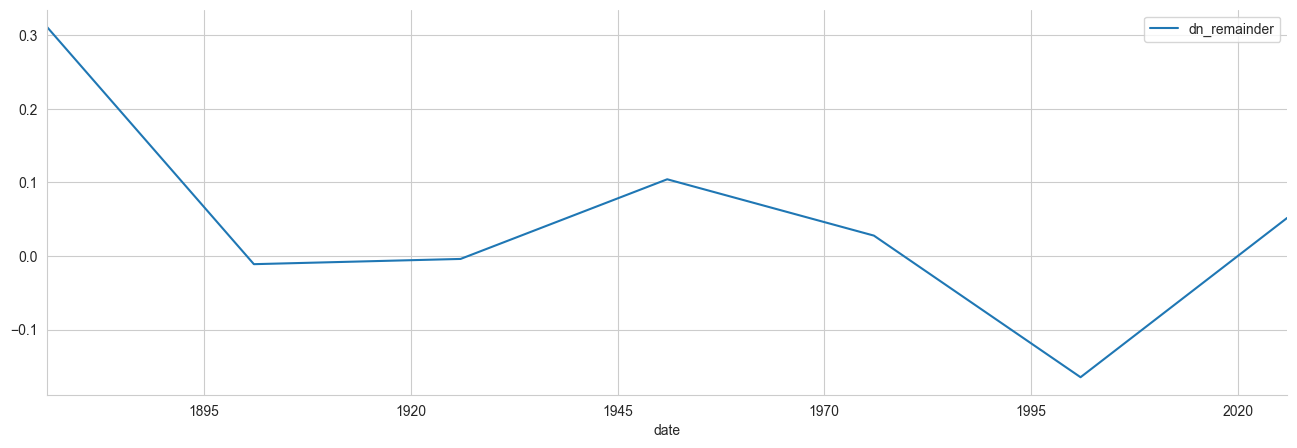

In [39]:
hlp.resampled_mean_plot(train["dn_remainder"], 25)

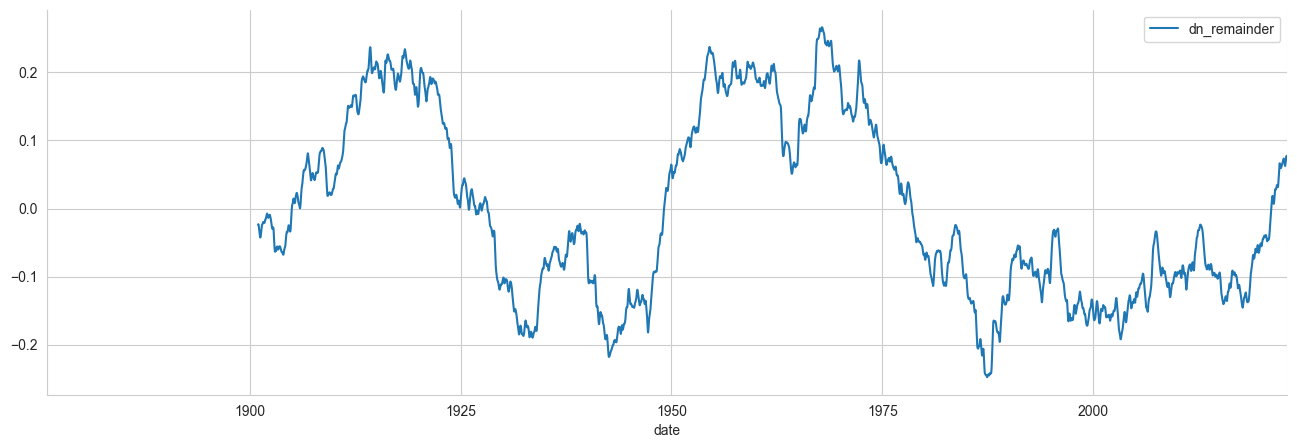

In [40]:
hlp.rolling_mean_plot(train['dn_remainder'], 25)

### Calculate difference
Since the remainder is heteroscedastic, calculate the first-order difference and try again.

In [41]:
train["dn_remainder_diff"] = train["dn_remainder"].diff(periods=1)
hlp.test_stationarity(train["dn_remainder_diff"].dropna())

p-values: 0.0 (ADF), 0.1 (KPSS)
Quartile coefficient of dispersion (QCD): 0.470928

Stationary or seasonal-stationary


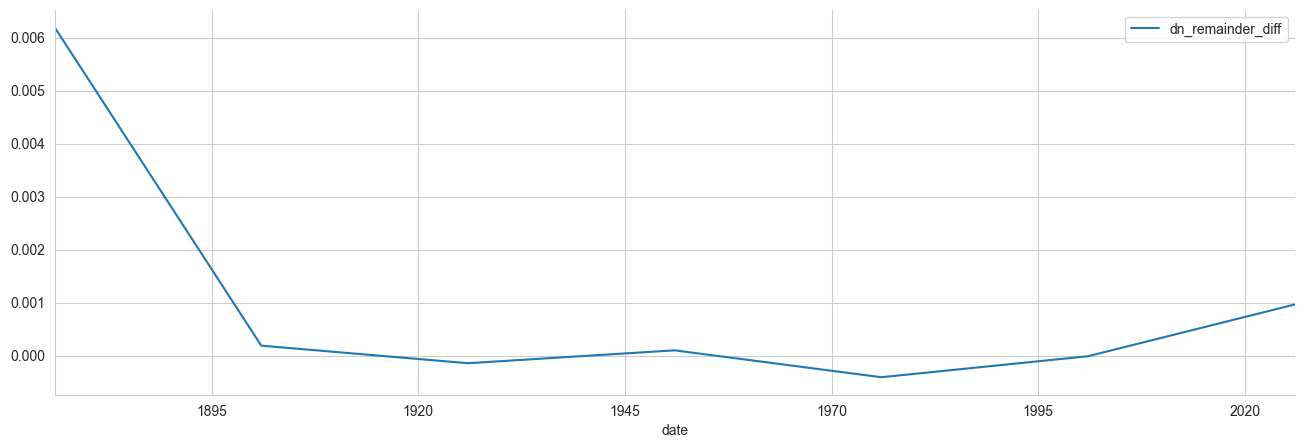

In [42]:
hlp.resampled_mean_plot(train["dn_remainder_diff"], 25)

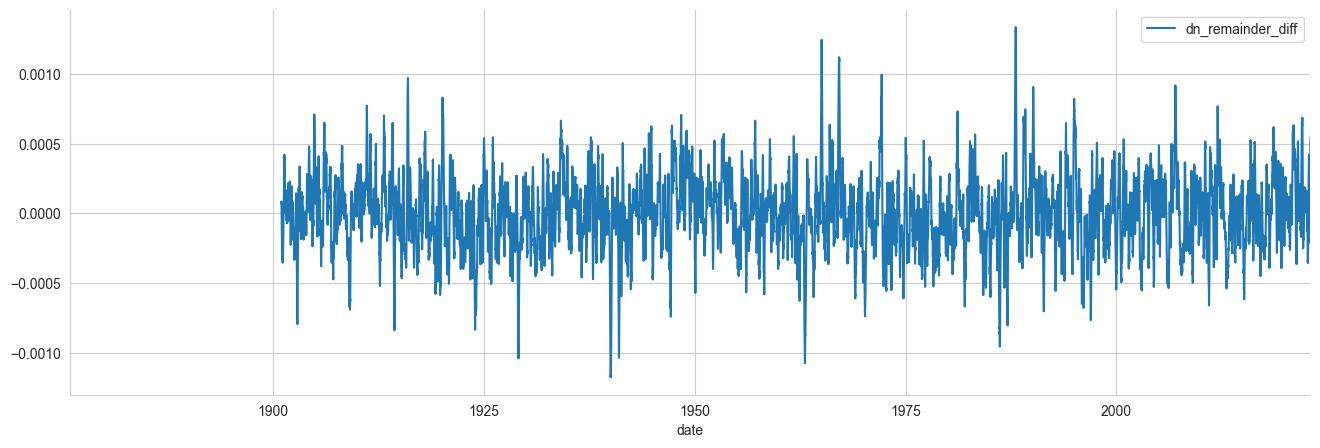

In [43]:
hlp.rolling_mean_plot(train['dn_remainder_diff'], 25)

### Build ARIMA model

In [44]:
run_auto_arima = False
file_name = "models/model_remainder.pkl"

if run_auto_arima:
    remainder_model = pm.auto_arima(
        train["dn_remainder"],
        start_p=0,
        max_p=5,
        start_q=0,
        max_q=5,
        seasonality=False,
        stationary=False,
        trace=True,
        n_jobs=-1,
    )

    # Save trained model
    joblib.dump(remainder_model, file_name)
else:
    remainder_model = joblib.load(file_name)

In [45]:
train["dn_remainder_pred"] = remainder_model.predict_in_sample()

In [46]:
# Combine trend, seasonality, and dn_remainder_pred
train['dn_trend_seasonal_pred'] = train['dn_trend'] + train['dn_seasonal'] + train["dn_remainder_pred"]

In [47]:
train.tail()

,timestep,temp,denoised,noise,dn_trend,dn_detrended,dn_seasonal,dn_trend_seasonal,dn_remainder,dn_remainder_diff,dn_remainder_pred,dn_trend_seasonal_pred
date,,,,,,,,,,,,
2022-12-27,53686,4.2,6.827954,-2.627954,10.357965,-6.157965,-8.349681,2.008284,4.819670,0.402839,4.699317,6.707601
2022-12-28,53687,6.3,7.212065,-0.912065,10.357999,-4.057999,-8.402881,1.955118,5.256947,0.437277,5.162171,7.117289
2022-12-29,53688,10.0,7.611574,2.388426,10.358033,-0.358033,-8.453435,1.904598,5.706976,0.450028,5.618155,7.522753
2022-12-30,53689,7.6,8.021626,-0.421626,10.358068,-2.758068,-8.501333,1.856735,6.164892,0.457916,6.075517,7.932252
2022-12-31,53690,14.8,8.411407,6.388593,10.358102,4.441898,-8.546565,1.811537,6.599870,0.434978,6.542206,8.353743


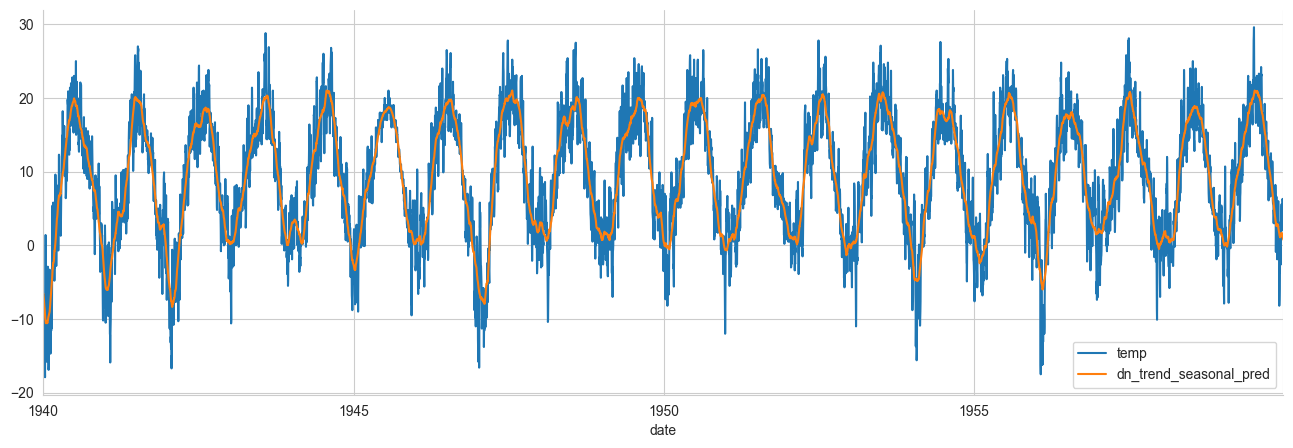

In [48]:
# Select a date range to show
df_plot = train[train.index.year.isin(range(1940, 1960))]

mpl.rc("figure", figsize=(16, 5))
df_plot[["temp", "dn_trend_seasonal_pred"]].plot(legend=True)
sns.despine()

## Handle the noise

Lastly, we handle the noise we extracted in the first step.

In [49]:
train[["noise"]].head()

,noise
date,
1876-01-01,2.859391
1876-01-02,3.272946
1876-01-03,1.158296
1876-01-04,-4.774506
1876-01-05,-8.648479


In [50]:
hlp.test_stationarity(train["noise"])

p-values: 0.0 (ADF), 0.1 (KPSS)
Quartile coefficient of dispersion (QCD): 0.486375

Stationary or seasonal-stationary


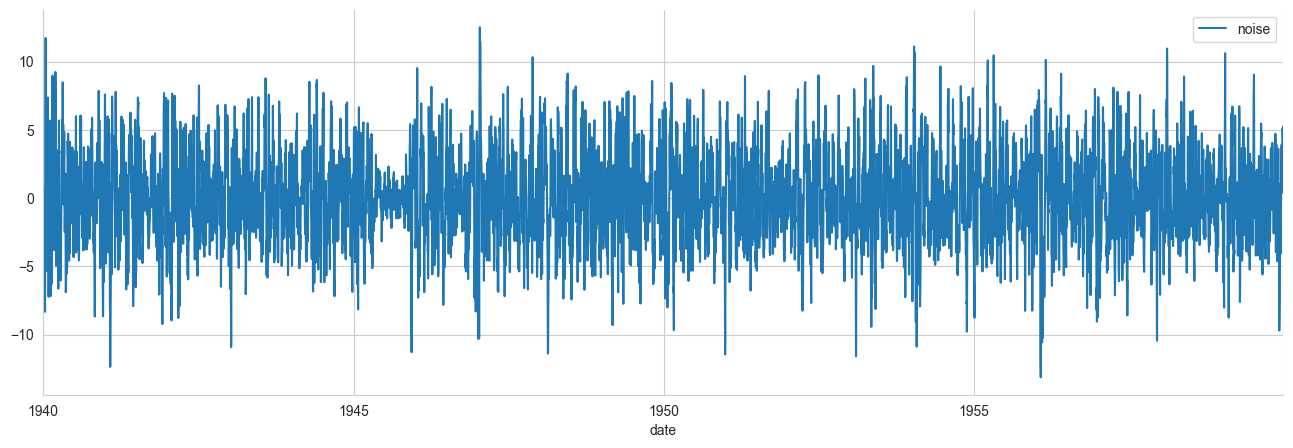

In [51]:
# Select a date range to show
df_plot = train[train.index.year.isin(range(1940, 1960))]

mpl.rc("figure", figsize=(16, 5))
df_plot[["noise"]].plot(legend=True)
sns.despine()

In [52]:
run_auto_arima = False
file_name = "models/model_noise.pkl"

if run_auto_arima:
    noise_model = pm.auto_arima(
        train['noise'], 
        start_p=0,
        max_p=3,
        start_q=0,
        max_q=3,
        seasonality=False,
        stationary=True,
        trace=True,
        n_jobs=-1,
    )

    # Save trained model
    joblib.dump(noise_model, file_name)
else:
    noise_model = joblib.load(file_name)

In [53]:
train["noise_pred"] = noise_model.predict_in_sample()

In [54]:
# Combine trend, seasonality, and dn_remainder_pred
train['total_pred'] = train['dn_trend_seasonal_pred'] + train['noise_pred']

In [55]:
train[["temp", "total_pred"]].tail(10)

,temp,total_pred
date,,
2022-12-22,7.2,6.220860
2022-12-23,6.5,6.998231
2022-12-24,6.5,6.258154
2022-12-25,4.9,6.563216
2022-12-26,9.5,5.180596
2022-12-27,4.2,9.664284
2022-12-28,6.3,4.094015
2022-12-29,10.0,7.443965
2022-12-30,7.6,10.044840


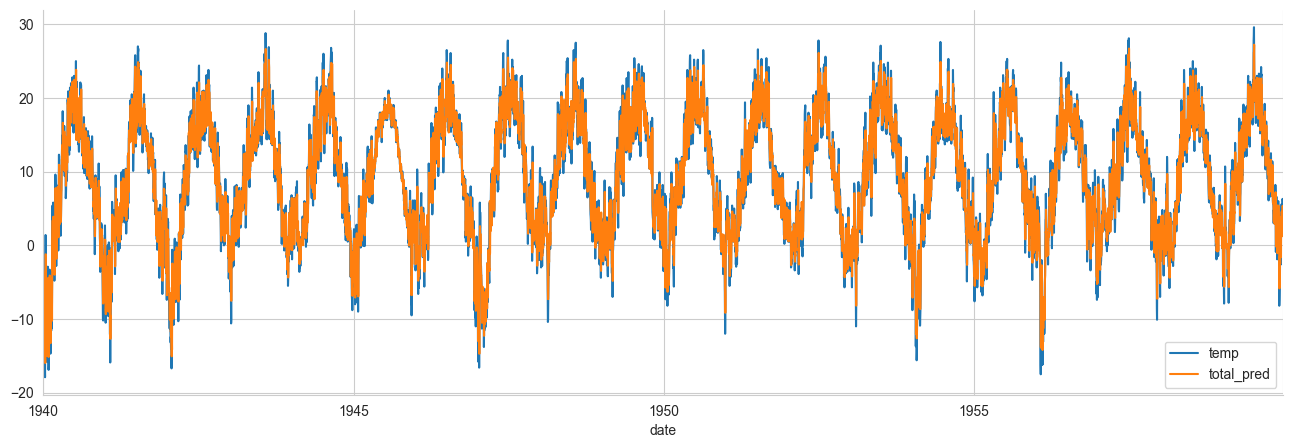

In [56]:
# Select a date range to show
df_plot = train[train.index.year.isin(range(1940, 1960))]

mpl.rc("figure", figsize=(16, 5))
df_plot[["temp", "total_pred"]].plot(legend=True)
sns.despine()

## Predict

Now we can predict the temperature for the next days using the models we built.

In [57]:
predictions = df_clean["2023-01-01":].copy()

predictions["trend"] = trend_model_cv.predict(predictions[["timestep"]])
predictions["season"] = seasonality_model_cv.predict(predictions[["timestep"]])
predictions["remainder"] = remainder_model.predict(len(predictions))
predictions["noise"] = noise_model.predict(len(predictions))
predictions["total"] = predictions["trend"] + predictions["season"] + predictions["remainder"] + predictions["noise"]
predictions["diff"] = predictions["total"] - predictions["temp"]

predictions[["temp", "total"]].head()

,temp,total
date,,
2023-01-01,14.5,14.549661
2023-01-02,13.1,12.692354
2023-01-03,5.6,11.536819
2023-01-04,7.1,10.785838
2023-01-05,8.2,10.340847


### Plot predictions

When we plot the predicted values next to the actual values, we can see that the model is able to predict the first days accurately. After that, the predictions are not as accurate anymore and predicted values are basically a combination of the trend and the seasonality.

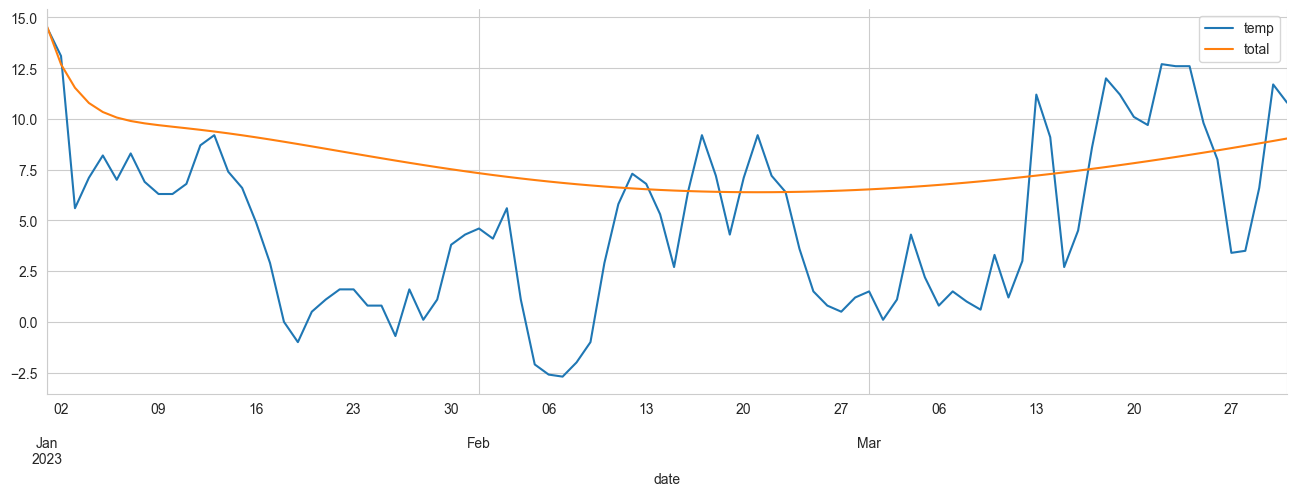

In [58]:
# Select a date range to show
df_plot = predictions[predictions.index.year.isin(range(1940, 1960))]

mpl.rc("figure", figsize=(16, 5))
predictions[["temp", "total"]].plot(legend=True)
sns.despine()

In [59]:
complete = train[["timestep", "temp", "total_pred"]].copy()
complete = pd.concat(
    [
        complete[["timestep", "temp", "total_pred"]],
        predictions[["timestep", "temp", "total"]],
    ]
)
complete.columns = ["timestep", "true_temp", "train", "prediction"]

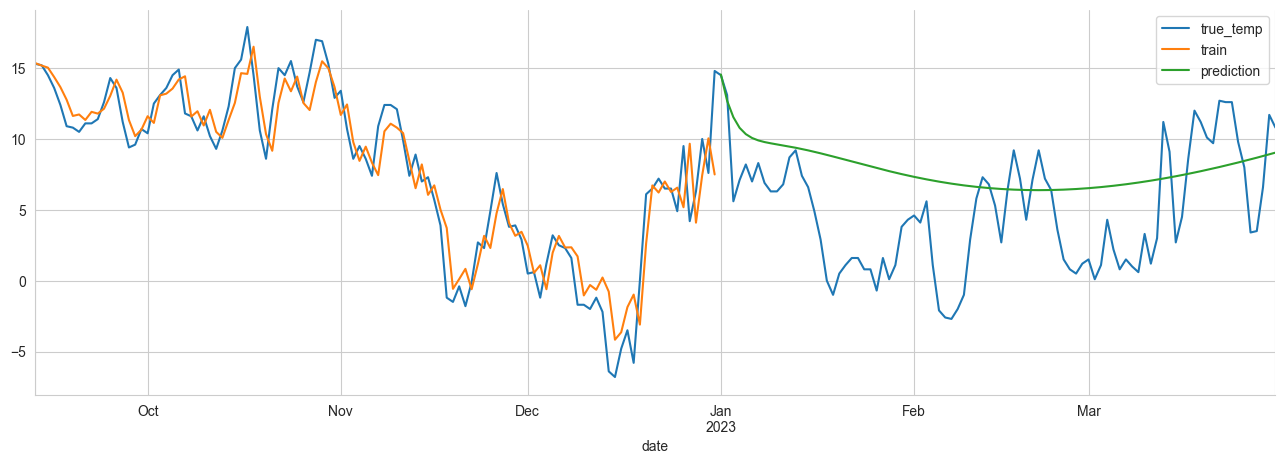

In [60]:
# Select a range to show
df_plot = complete[-200:]

mpl.rc("figure", figsize=(16, 5))
df_plot[["true_temp", "train", "prediction"]].plot(legend=True)
sns.despine()

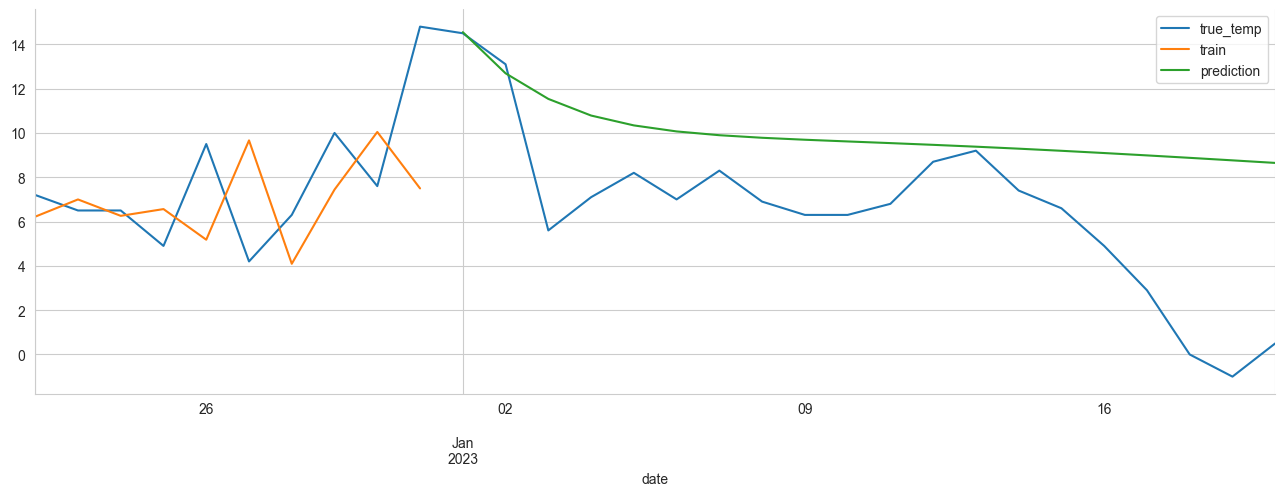

In [61]:
# Select a range to show
df_plot = complete[-100:-70]

mpl.rc("figure", figsize=(16, 5))
df_plot[["true_temp", "train", "prediction"]].plot(legend=True)
sns.despine()